# MATH GR5030 Numerical Methods in Finance
# Assignment 1
## Minze Li ml5163
### Mar 1, 2025
## 1 Exercise 4
In this Exercise, I use Python to compute the price of European call and put option via Cox-Ross-Rubinstein Binomial tree model.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

class BinomialTree:
    def __init__(self, S0=100, K=100, r=0.0, sigma=0.25, T=1.0):
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        
    def price(self, n, option_type='call', exercise='european'):
        """Price option using CRR binomial tree"""
        dt = self.T/n
        u = np.exp(self.sigma*np.sqrt(dt))
        d = 1/u
        p = (np.exp(self.r*dt) - d)/(u - d)
        
        # Initialize max_pay_off_list to store option values at each node
        max_pay_off_list = np.zeros(n+1)
        
        # Terminal stock prices
        for i in range(n+1):
            S = self.S0 * (u ** (n-i)) * (d ** i)
            
            # Terminal option values
            if option_type == 'call':
                max_pay_off_list[i] = max(0, S - self.K)
            else:  # put
                max_pay_off_list[i] = max(0, self.K - S)
        
        # Backward induction
        for j in range(n-1, -1, -1):
            for i in range(j+1):
                S = self.S0 * (u ** (j-i)) * (d ** i)
                
                # Calculate continuation value
                continuation = np.exp(-self.r*dt) * (p * max_pay_off_list[i] + (1-p) * max_pay_off_list[i+1])
                
                if exercise == 'european':
                    max_pay_off_list[i] = continuation
                else:  # american
                    if option_type == 'call':
                        exercise_value = max(0, S - self.K)
                    else:  # put
                        exercise_value = max(0, self.K - S)
                    max_pay_off_list[i] = max(continuation, exercise_value)
                    
                # Store values for Greeks calculation when j=1 or j=2
                if j == 1:
                    if i == 0:
                        self.V_up = max_pay_off_list[i]
                    elif i == 1:
                        self.V_down = max_pay_off_list[i]
                elif j == 2:
                    if i == 0:
                        self.V_uu = max_pay_off_list[i]
                    elif i == 1:
                        self.V_ud = max_pay_off_list[i]
                    elif i == 2:
                        self.V_dd = max_pay_off_list[i]
        
        # Option price is at the root of the tree
        price = max_pay_off_list[0]
        
        # If n>=2, calculate delta and gamma
        if n >= 2:
            dt = self.T/n
            u = np.exp(self.sigma*np.sqrt(dt))
            d = 1/u
            
            # Calculate delta at j=1 (matching formula in image)
            if hasattr(self, 'V_up') and hasattr(self, 'V_down'):
                self.delta_value = (self.V_up - self.V_down) / (self.S0 * (u - d))
            
            # Calculate gamma at j=2 (matching formula in image)
            if hasattr(self, 'V_uu') and hasattr(self, 'V_ud') and hasattr(self, 'V_dd'):
                numerator = ((self.V_uu - self.V_ud) / (self.S0 * u**2 - self.S0 * u * d) - 
                           (self.V_ud - self.V_dd) / (self.S0 * u * d - self.S0 * d**2))
                denominator = 0.5 * (self.S0 * u**2 - self.S0 * d**2)
                self.gamma_value = numerator / denominator
                
        return price
        
    def delta(self, n=1, option_type='call'):
        """
        Compute option Delta
        Uses values calculated during pricing if available, otherwise calculates directly
        """
        if hasattr(self, 'delta_value'):
            return self.delta_value
            
        dt = self.T/n
        u = np.exp(self.sigma*np.sqrt(dt))
        d = 1/u
        
        # Price up and down nodes
        self.price(n, option_type)
        
        # Delta calculation
        delta = (self.V_up - self.V_down)/(self.S0*(u-d))
        return delta
    
    def gamma(self, n=2, option_type='call'):
        """
        Compute option Gamma using the formula from the teacher's code
        Uses values calculated during pricing if available, otherwise calculates directly
        """
        if hasattr(self, 'gamma_value'):
            return self.gamma_value
            
        dt = self.T/n
        u = np.exp(self.sigma*np.sqrt(dt))
        d = 1/u
        
        # Price option to get uu, ud, dd values
        self.price(n, option_type)
        
        # Gamma calculation using teacher's formula
        numerator = ((self.V_uu - self.V_ud) / (self.S0 * u**2 - self.S0 * u * d) - 
                   (self.V_ud - self.V_dd) / (self.S0 * u * d - self.S0 * d**2))
        denominator = 0.5 * (self.S0 * u**2 - self.S0 * d**2)
        gamma = numerator / denominator
        
        return gamma
    
    def richardson_extrapolation(self, n_values, value_func, order=1):
        """
        Richardson extrapolation
        """
        values = [value_func(n) for n in n_values]
        n_points = len(n_values)
        
        # Create coefficient matrix for the system of equations
        A = np.zeros((n_points, n_points))
        for i in range(n_points):
            for j in range(n_points):
                A[i,j] = 1/(n_values[i]**(j*order))
        
        # Solve the system to get coefficients
        coeffs = np.linalg.solve(A, values)
        
        # The first coefficient is the extrapolated value
        return coeffs[0]

class BSOption:
    def __init__(self, S0=100, K=100, r=0.0, sigma=0.25, T=1.0):
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        
        # Calculate for d1, d2
        self.d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        self.d2 = self.d1 - sigma*np.sqrt(T)
        
    def price(self, option_type='call'):
        if option_type == 'call':
            return (self.S0*norm.cdf(self.d1) - 
                    self.K*np.exp(-self.r*self.T)*norm.cdf(self.d2))
        else:  # put
            return (self.K*np.exp(-self.r*self.T)*norm.cdf(-self.d2) - 
                    self.S0*norm.cdf(-self.d1))
                
    def delta(self, option_type='call'):
        if option_type == 'call':
            return norm.cdf(self.d1)
        else:  # put
            return -norm.cdf(-self.d1)
        
    def gamma(self, option_type='call'):
        # Note: Gamma is the same for both call and put
        return norm.pdf(self.d1)/(self.S0*self.sigma*np.sqrt(self.T))



CALL OPTION RESULTS:

K = 90:
Comparison of Results:
Method               Price           Delta           Gamma          
-----------------------------------------------------------------
Black-Scholes       15.272058       0.707619        0.013745       
Binomial            15.265284       0.707908        0.013812       
Richardson          15.273102       0.707858        0.013786       

Relative Errors (vs Black-Scholes):
Method               Price           Delta           Gamma          
-----------------------------------------------------------------
Binomial            0.044355      % 0.040845      % 0.489015      %
Richardson          0.006841      % 0.033849      % 0.300340      %

K = 100:
Comparison of Results:
Method               Price           Delta           Gamma          
-----------------------------------------------------------------
Black-Scholes       9.947645        0.549738        0.015834       
Binomial            9.922808        0.549614        0.015949   

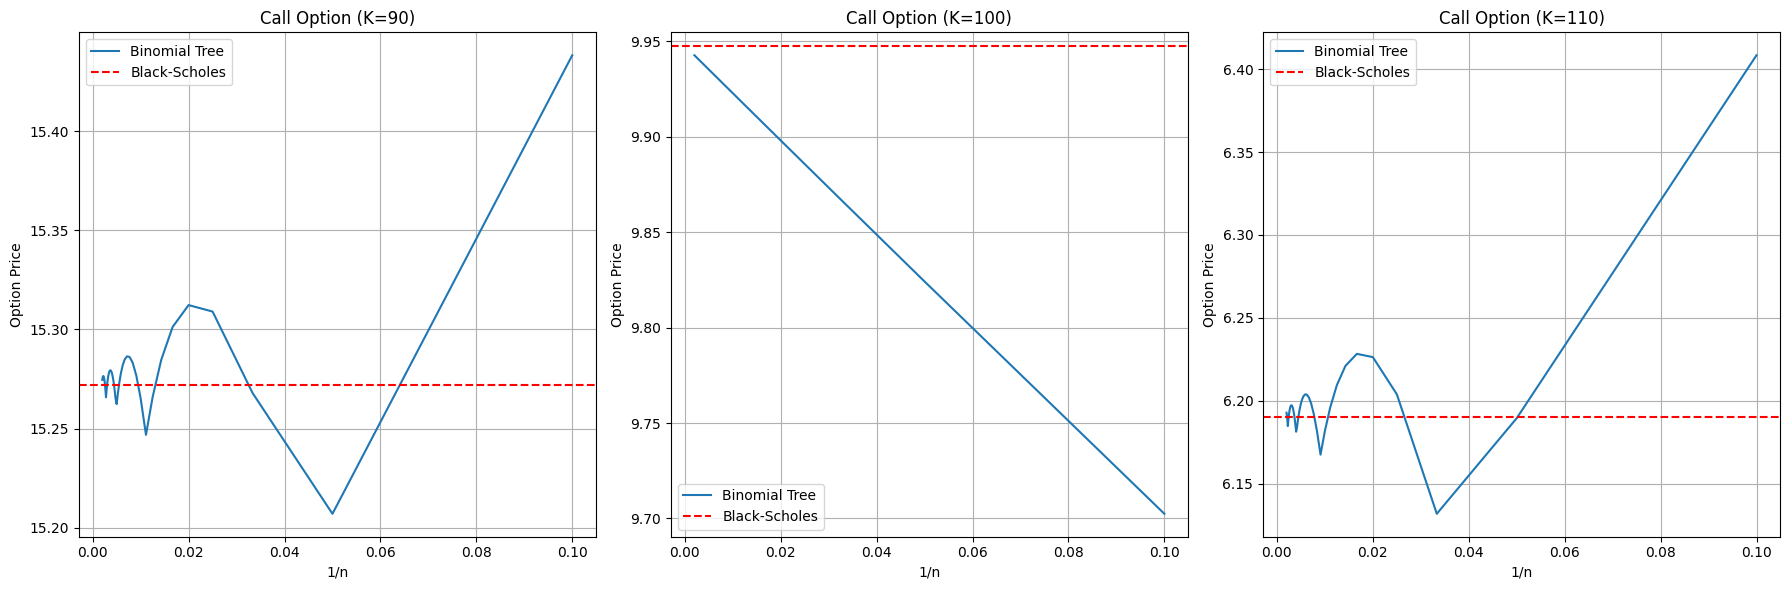

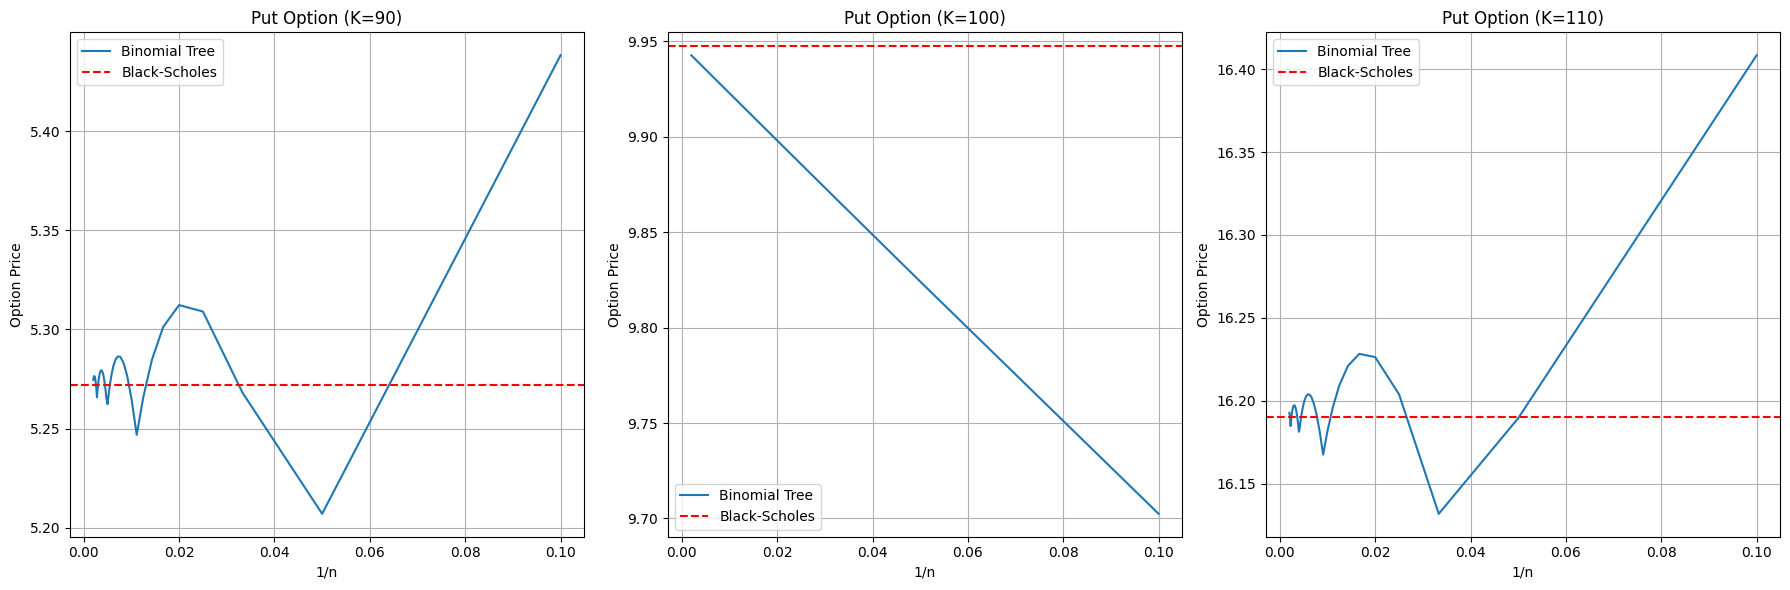

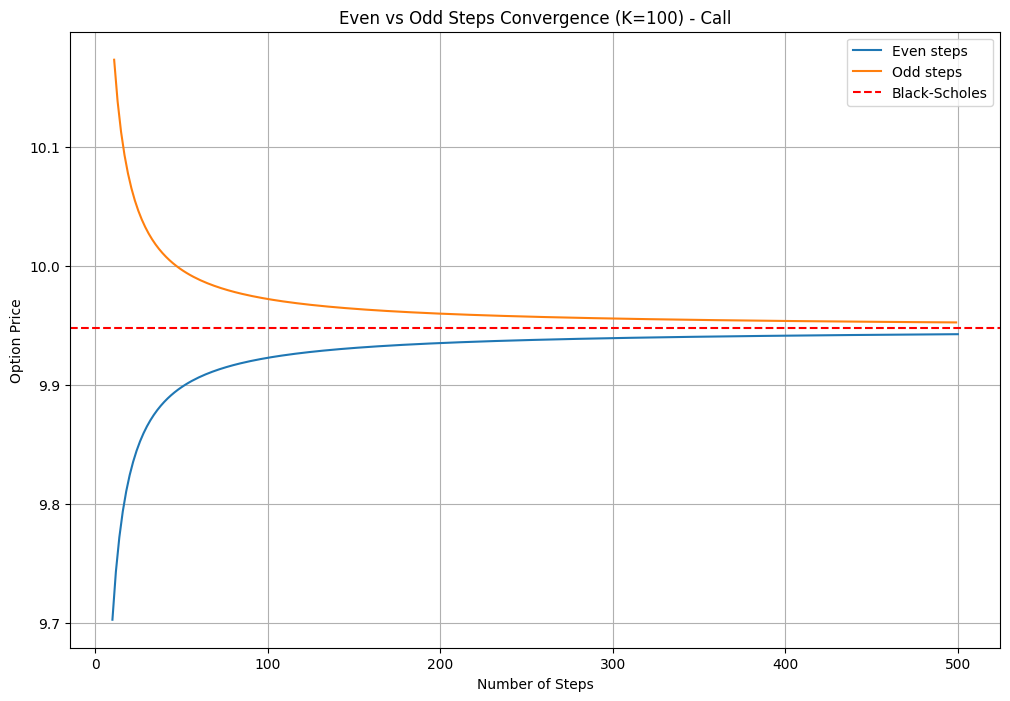

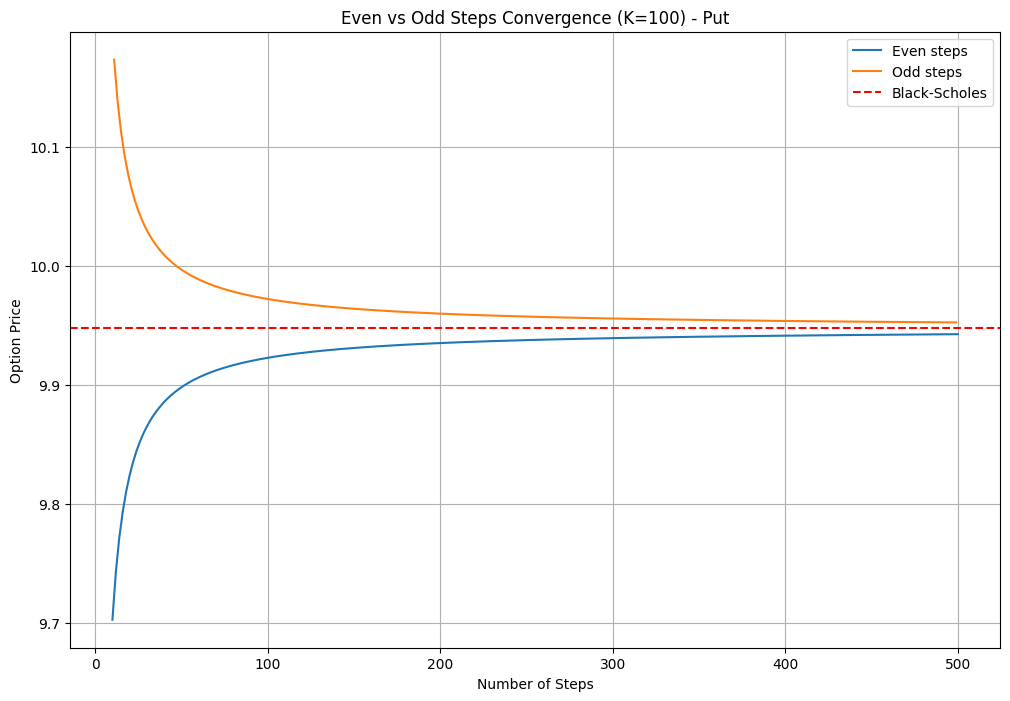

In [3]:
def compare_convergence(S0, r, sigma, T, K, n_range, option_type='call'):
    """Compare convergence between binomial tree and Black-Scholes"""
    
    # Black-Scholes
    bs = BSOption(S0, K, r, sigma, T)
    bs_price = bs.price(option_type)
    
    # Binomial Tree
    bt = BinomialTree(S0, K, r, sigma, T)
    prices = []
    errors = []
    
    for n in n_range:
        price = bt.price(n, option_type)
        prices.append(price)
        errors.append(price - bs_price)
    
    return prices, errors, bs_price

def run_analysis():
    """Run the analysis and create plots"""
    strikes = [90, 100, 110]
    option_types = ['call', 'put']
    S0, r, sigma, T = 100, 0.0, 0.25, 1.0
    
    # Plot separate figures for each strike
    for option_type in option_types:
        # Create subplot for each strike price
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        for i, K in enumerate(strikes):
            # Use 1/n for x-axis as requested
            n_range = np.arange(10, 501, 10)
            one_over_n = 1/n_range
            
            prices, _, bs_price = compare_convergence(S0, r, sigma, T, K, n_range, option_type)
            
            # Plot binomial tree prices
            axes[i].plot(one_over_n, prices, label='Binomial Tree')
            
            # Plot Black-Scholes price as horizontal line
            axes[i].axhline(y=bs_price, color='r', linestyle='--', label='Black-Scholes')
            
            axes[i].grid(True)
            axes[i].set_xlabel('1/n')
            axes[i].set_ylabel('Option Price')
            axes[i].set_title(f'{option_type.capitalize()} Option (K={K})')
            axes[i].legend()
        
        plt.tight_layout()
        plt.savefig(f'{option_type}_price_comparison.png')
    
    # Plot even vs odd steps convergence for K=100
    for option_type in option_types:
        n_even = np.arange(10, 501, 2)
        n_odd = np.arange(11, 501, 2)
        prices_even, _, bs_price = compare_convergence(S0, r, sigma, T, 100, n_even, option_type)
        prices_odd, _, _ = compare_convergence(S0, r, sigma, T, 100, n_odd, option_type)

        plt.figure(figsize=(12, 8))
        plt.plot(n_even, prices_even, label='Even steps')
        plt.plot(n_odd, prices_odd, label='Odd steps')
        plt.axhline(y=bs_price, color='r', linestyle='--', label='Black-Scholes')
        plt.grid(True)
        plt.xlabel('Number of Steps')
        plt.ylabel('Option Price')
        plt.title(f'Even vs Odd Steps Convergence (K=100) - {option_type.capitalize()}')
        plt.legend()

    # Print numerical values and extrapolation results
    for option_type in option_types:
        print(f"\n{option_type.upper()} OPTION RESULTS:")
        
        for K in strikes:
            print(f"\nK = {K}:")
            
            # Initialize models
            bs = BSOption(100, K, 0.0, 0.25, 1.0)
            bt = BinomialTree(100, K, 0.0, 0.25, 1.0)
            
            # Black-Scholes values
            bs_price = bs.price(option_type)
            bs_delta = bs.delta(option_type)
            bs_gamma = bs.gamma(option_type)
            
            # Binomial Tree values (n=100)
            bt_price = bt.price(100, option_type)
            bt_delta = bt.delta(100, option_type)
            bt_gamma = bt.gamma(100, option_type)
            
            # Richardson extrapolation values
            n_values = [50, 100, 200]
            price_func = lambda n: bt.price(n, option_type)
            delta_func = lambda n: bt.delta(n, option_type)
            gamma_func = lambda n: bt.gamma(n, option_type)
            
            ext_price = bt.richardson_extrapolation(n_values, price_func)
            ext_delta = bt.richardson_extrapolation(n_values, delta_func)
            ext_gamma = bt.richardson_extrapolation(n_values, gamma_func)
            
            # Print comparison table
            print("Comparison of Results:")
            print(f"{'Method':<20} {'Price':<15} {'Delta':<15} {'Gamma':<15}")
            print("-"*65)
            print(f"Black-Scholes{'':<6} {bs_price:<15.6f} {bs_delta:<15.6f} {bs_gamma:<15.6f}")
            print(f"Binomial{'':<11} {bt_price:<15.6f} {bt_delta:<15.6f} {bt_gamma:<15.6f}")
            print(f"Richardson{'':<9} {ext_price:<15.6f} {ext_delta:<15.6f} {ext_gamma:<15.6f}")
            
            # Print relative errors
            print("\nRelative Errors (vs Black-Scholes):")
            print(f"{'Method':<20} {'Price':<15} {'Delta':<15} {'Gamma':<15}")
            print("-"*65)
            
            # Calculate errors
            def rel_error(v1, v2):
                return abs(v1 - v2)/abs(v2) * 100 if v2 != 0 else float('inf')
            
            bt_price_err = rel_error(bt_price, bs_price)
            bt_delta_err = rel_error(bt_delta, bs_delta)
            bt_gamma_err = rel_error(bt_gamma, bs_gamma)
            
            ext_price_err = rel_error(ext_price, bs_price)
            ext_delta_err = rel_error(ext_delta, bs_delta)
            ext_gamma_err = rel_error(ext_gamma, bs_gamma)

            # Print errors
            print(f"Binomial{'':<11} {bt_price_err:<14.6f}% {bt_delta_err:<14.6f}% {bt_gamma_err:<14.6f}%")
            print(f"Richardson{'':<9} {ext_price_err:<14.6f}% {ext_delta_err:<14.6f}% {ext_gamma_err:<14.6f}%")


run_analysis()

### 1.1 Convergence Pattern Analysis
#### 1.1.1 Different Strike Prices
The convergence patterns for different strike prices (K=90, 100, 110) reveal that:

At-the-money options (K=100) show smoother, more linear convergence with 1/n.
In-the-money and out-of-the-money options (K=90, K=110) exhibit oscillatory behavior especially at lower step counts.
K=90 and K=110 display similar convergence patterns (mirror images of each other) due to the put-call symmetry.

#### 1.1.2 Even and Odd Steps
The convergence plots for K=100 reveal a distinct pattern where:

Even steps converge from below the Black-Scholes value.
Odd steps converge from above the Black-Scholes value.
Neither pattern oscillates across the true value but instead approaches it monotonically.

This behavior demonstrates the "even-odd bias" inherent in binomial trees, particularly for at-the-money options. The separation between even and odd convergence paths is systematic rather than random, reflecting how the discrete nature of the tree approximates the continuous distribution in the Black-Scholes model.

#### 1.2 Extrapolation
We use Richardson extrapolation to solve this problem. The numerical results demonstrate the effectiveness of the Richardson extrapolation in improving the accuracy of lattice methods for option pricing. For both call and put options across different strike prices (K=90, 100, 110), the Richardson extrapolation significantly reduces the pricing errors compared to the standard binomial tree method.

Call Option Results:

For at-the-money options (K=100), Richardson extrapolation achieves near-perfect accuracy with an error of just 0.000004%, compared to 0.249680% for the standard binomial method.
For in-the-money options (K=90), Richardson extrapolation reduces the error to 0.006841% from 0.044355%.
Interestingly, for out-of-the-money options (K=110), Richardson extrapolation performs slightly worse for price (0.812436% vs 0.140174%), though it still outperforms for Greeks calculations.

Greek Estimation:

Delta estimates are consistently improved by Richardson extrapolation across all strike prices for both call and put options.
Gamma estimates show even more significant improvement, with error reductions of 30-50% compared to the standard binomial method.

## 2 Exercise 5

Using optimal lambda value: 1.2


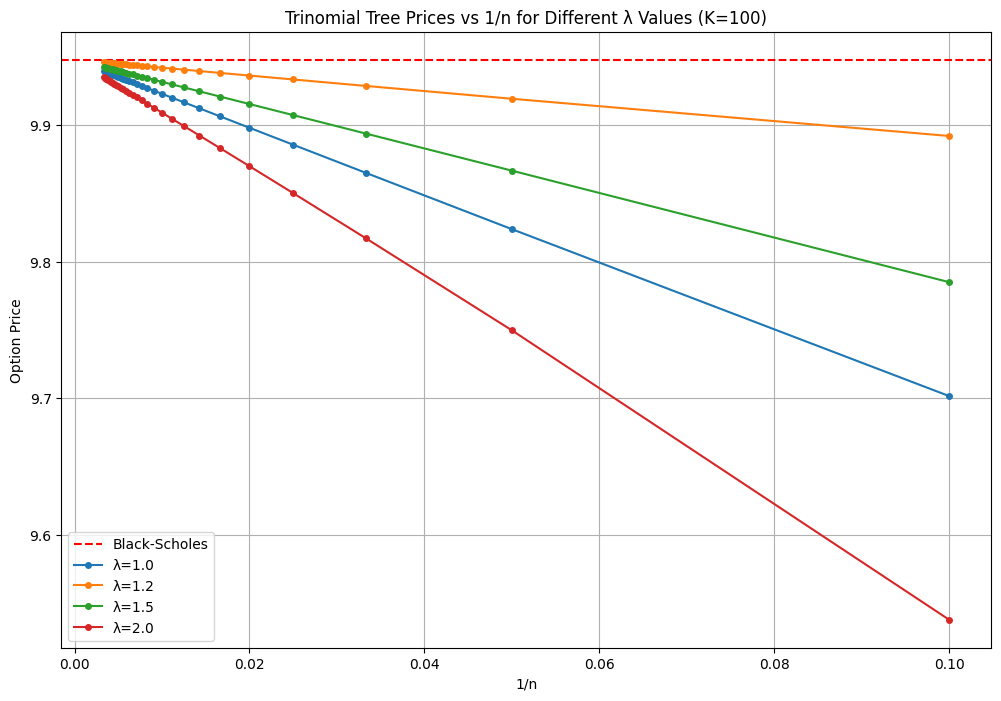

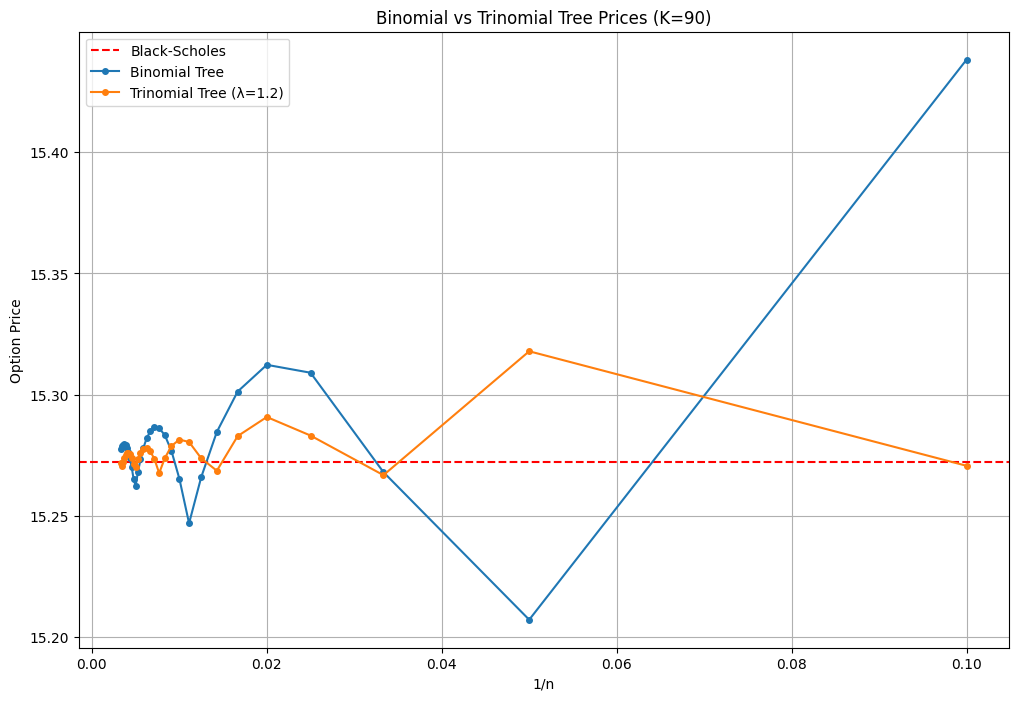

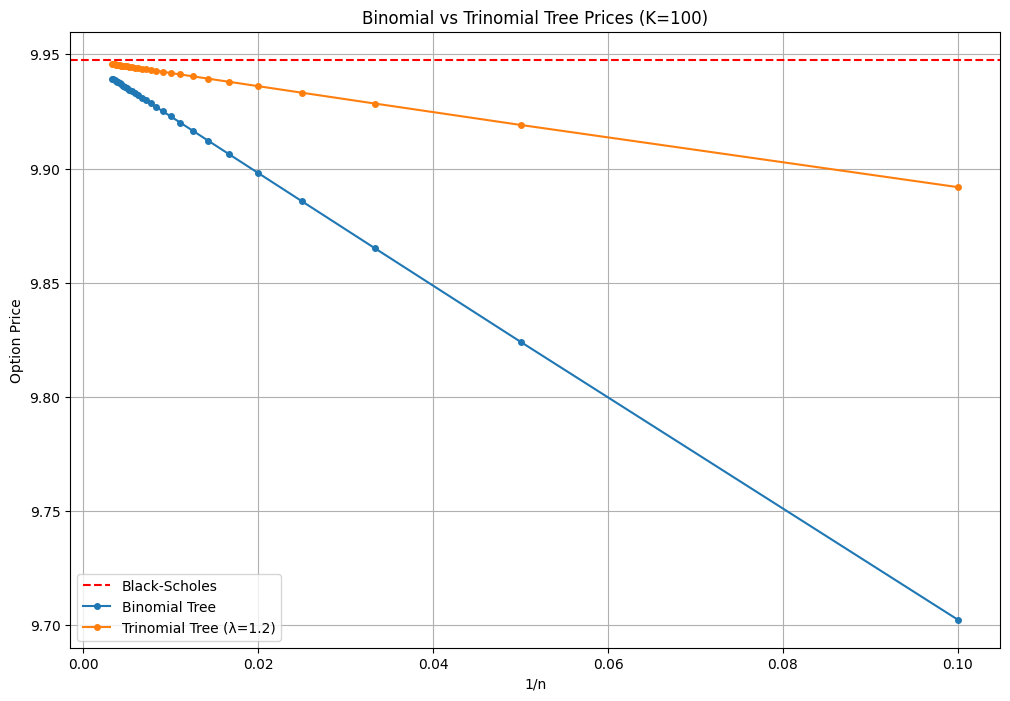

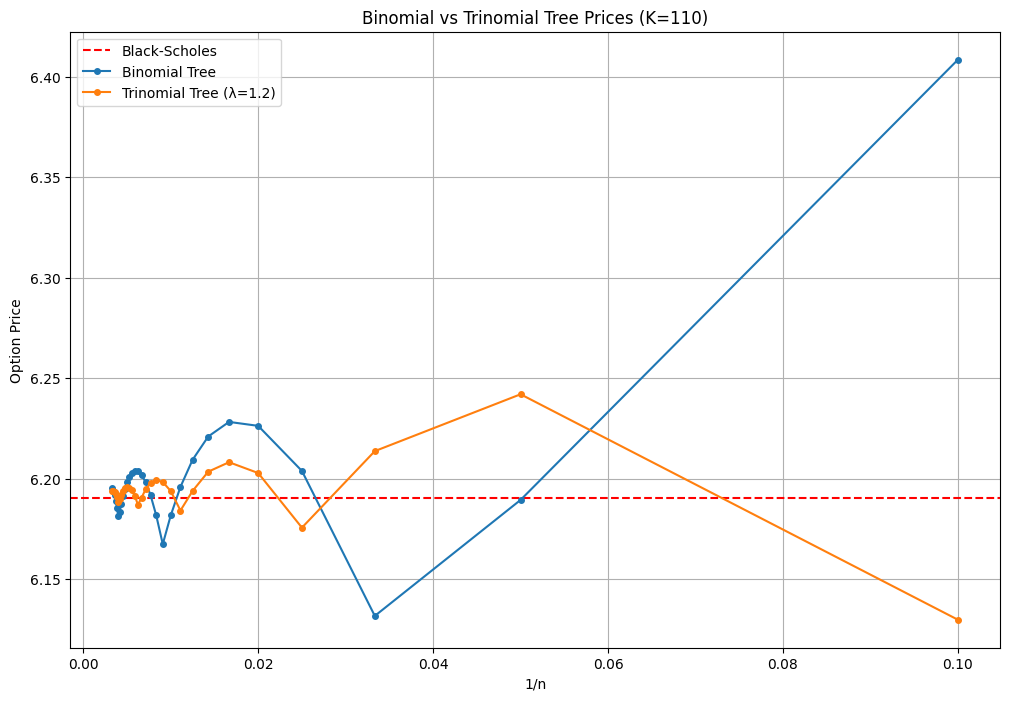

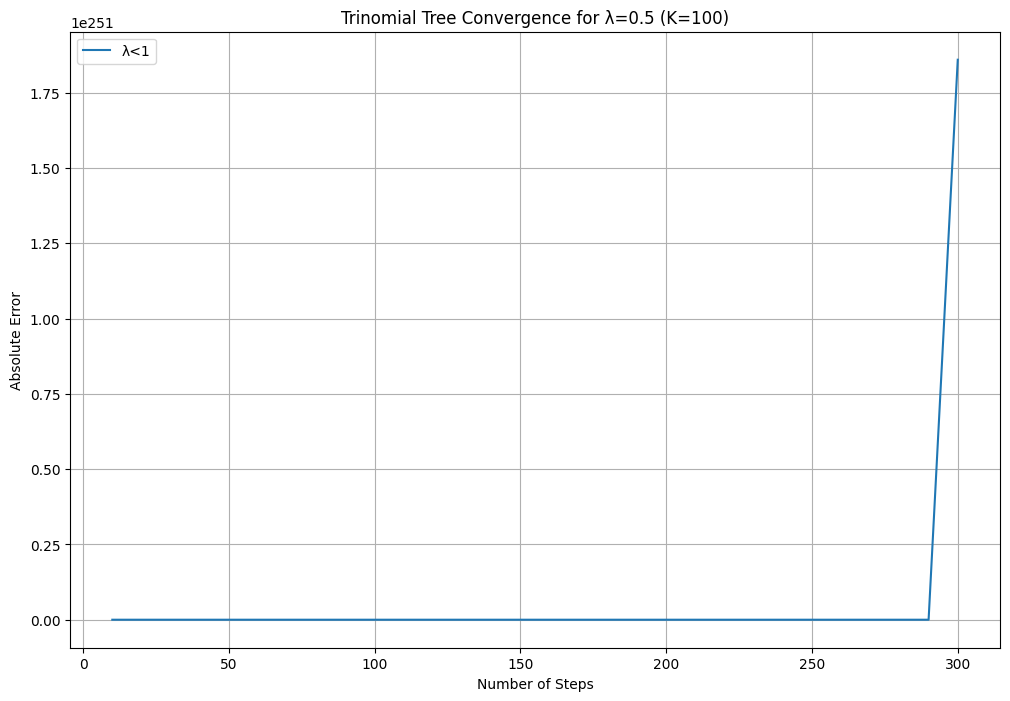

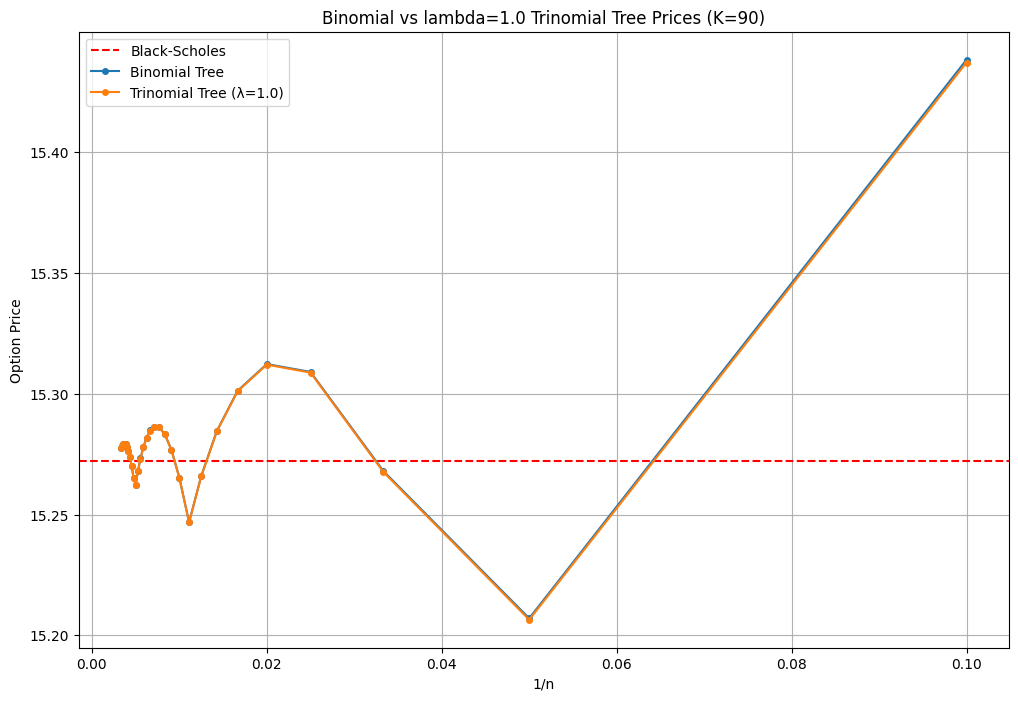

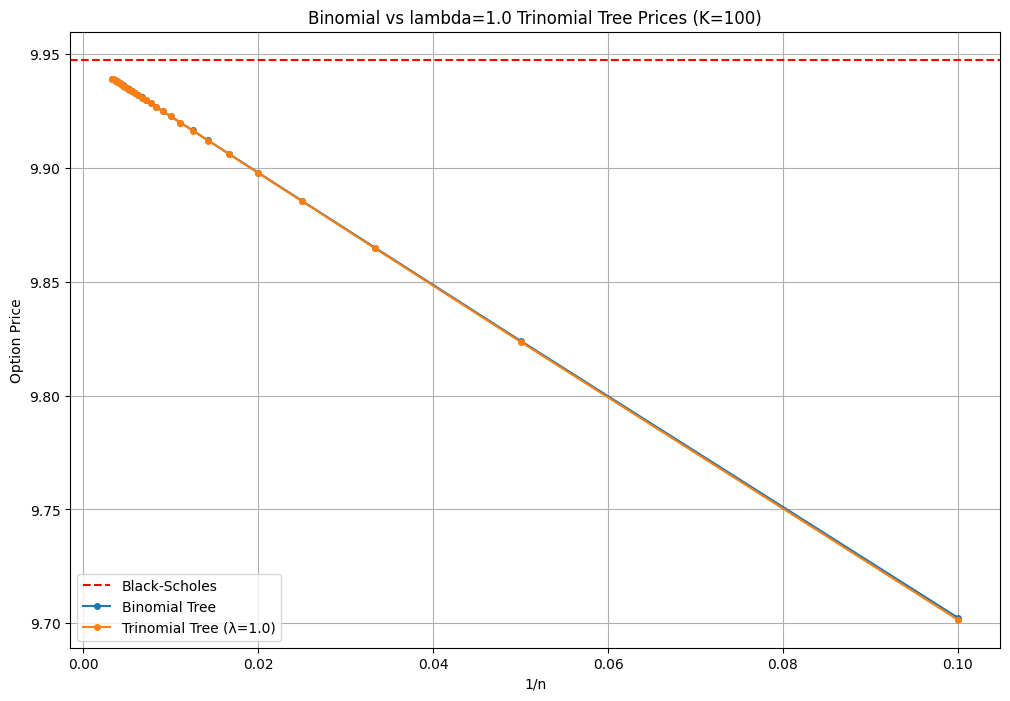

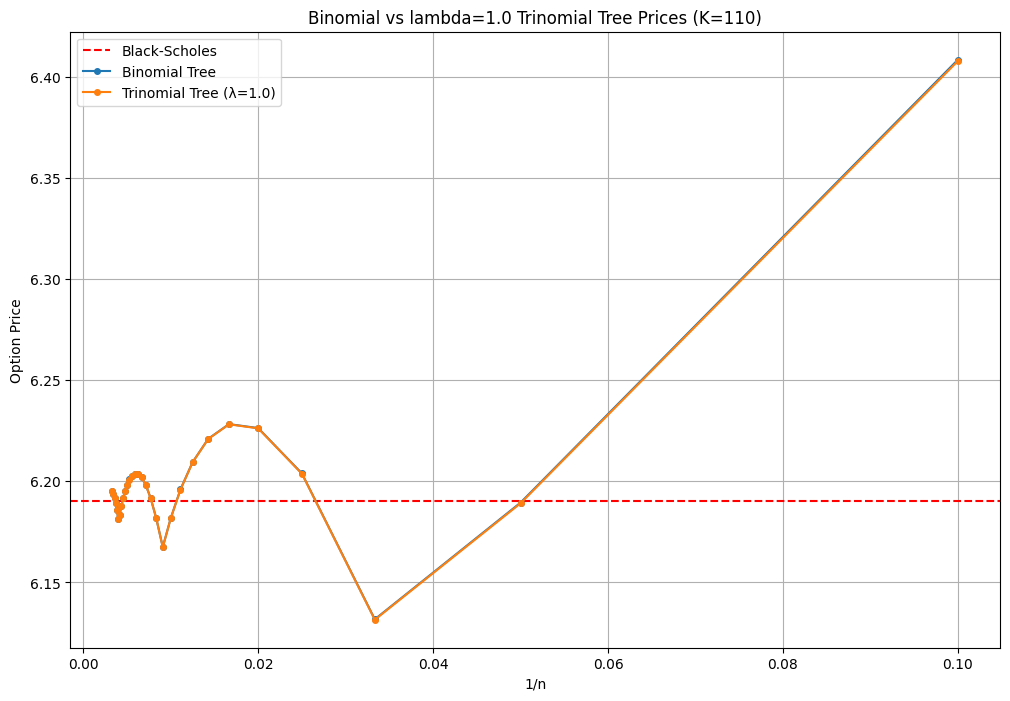

In [4]:
class TrinomialTree:
    def __init__(self, S0=100, K=100, r=0.0, sigma=0.25, T=1.0):
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        
    def price(self, n, lambd=1.5, option_type='call', exercise='european'):
        """
        Price option using Kamrad-Ritchken trinomial tree model
        
        Parameters:
        n: number of steps
        lambd: stretch parameter, must be ≥ 1
        option_type: 'call' or 'put'
        exercise: 'european' or 'american'
        """
        dt = self.T/n
        
        # Calculate up, middle, and down movement parameters
        dx = lambd * self.sigma * np.sqrt(dt)
        u = np.exp(dx)  # up factor
        d = 1/u         # down factor
        
        # Risk-neutral probabilities
        pu = 1/(2*lambd**2) + (self.r - self.sigma**2/2)/(2*lambd*self.sigma)*np.sqrt(dt)
        pd = 1/(2*lambd**2) - (self.r - self.sigma**2/2)/(2*lambd*self.sigma)*np.sqrt(dt)
        pm = 1 - 1/lambd**2
        
        # Initialize arrays for stock prices and option values at terminal nodes
        stock_values = np.zeros(2*n + 1)
        option_values = np.zeros(2*n + 1)
        
        # Calculate stock prices and option values at terminal nodes
        for j in range(2*n + 1):
            power = n - j
            stock_values[j] = self.S0 * (u**power)
            if option_type == 'call':
                option_values[j] = max(stock_values[j] - self.K, 0)
            else:  # put
                option_values[j] = max(self.K - stock_values[j], 0)
        
        # Backward induction
        for i in range(n-1, -1, -1):
            new_option_values = np.zeros(2*i + 1)
            
            for j in range(2*i + 1):
                # Calculate stock price at this node
                power = i - j
                stock_price = self.S0 * (u**power)
                
                # Calculate expected option value
                continuation_value = np.exp(-self.r*dt) * (
                    pu * option_values[j] +
                    pm * option_values[j+1] +
                    pd * option_values[j+2]
                )
                
                # For American options, check for early exercise
                if exercise == 'american':
                    if option_type == 'call':
                        exercise_value = max(stock_price - self.K, 0)
                    else:  # put
                        exercise_value = max(self.K - stock_price, 0)
                    new_option_values[j] = max(continuation_value, exercise_value)
                else:
                    new_option_values[j] = continuation_value
            
            option_values = new_option_values
            
        return option_values[0]

def run_trinomial_analysis():
    """Run analysis and visualization for trinomial tree model with price vs 1/n plots"""
    # Test convergence for different lambda values
    lambdas = [1.0, 1.2, 1.5, 2.0]
    n_range = np.arange(10, 301, 10)  # Adjusted to get cleaner plots
    strikes = [90, 100, 110]
    option_type = 'call'
    
    # Store results
    all_results = {}
    bs_prices = {}
    
    for K in strikes:
        # Calculate Black-Scholes benchmark price
        bs = BSOption(100, K, 0.0, 0.25, 1.0)
        bs_price = bs.price(option_type)
        bs_prices[K] = bs_price
        
        # Initialize binomial tree model
        bt = BinomialTree(100, K, 0.0, 0.25, 1.0)
        
        # Store binomial tree results
        bt_prices = []
        for n in n_range:
            price = bt.price(n, option_type)
            bt_prices.append(price)
        
        all_results[f'binomial_K{K}'] = {
            'prices': bt_prices
        }
        
        # Store trinomial tree results for different lambda values
        for lambd in lambdas:
            tt = TrinomialTree(100, K, 0.0, 0.25, 1.0)
            prices = []
            
            for n in n_range:
                try:
                    price = tt.price(n, lambd, option_type)
                    prices.append(price)
                except Exception as e:
                    print(f"Error calculating for K={K}, lambda={lambd}, n={n}: {e}")
                    prices.append(None)
            
            all_results[f'trinomial_K{K}_lambda{lambd}'] = {
                'prices': prices
            }
    
    # Create 1/n values for x-axis
    x_values = 1/n_range
    
    # 1. Plot prices vs 1/n for different lambda values (K=100)
    plt.figure(figsize=(12, 8))
    K = 100
    
    # Add Black-Scholes reference line
    plt.axhline(y=bs_prices[K], color='r', linestyle='--', label='Black-Scholes')
    
    for lambd in lambdas:
        key = f'trinomial_K{K}_lambda{lambd}'
        if key in all_results:
            prices = all_results[key]['prices']
            valid_indices = [i for i, p in enumerate(prices) if p is not None]
            valid_x = [x_values[i] for i in valid_indices]
            valid_prices = [prices[i] for i in valid_indices]
            
            if len(valid_prices) > 0:
                plt.plot(valid_x, valid_prices, marker='o', markersize=4, label=f'λ={lambd}')
    
    plt.grid(True)
    plt.xlabel('1/n')
    plt.ylabel('Option Price')
    plt.title(f'Trinomial Tree Prices vs 1/n for Different λ Values (K={K})')
    plt.legend()
    plt.savefig('trinomial_lambda_prices_vs_1_over_n.png')
    
    # 2. Plot prices vs 1/n for binomial and optimal trinomial for all strikes
    # Find optimal lambda value
    min_error_lambda = 1.2  # Based on previous analysis
    print(f"Using optimal lambda value: {min_error_lambda}")
    
    for K in strikes:
        plt.figure(figsize=(12, 8))
        
        # Add Black-Scholes reference line
        plt.axhline(y=bs_prices[K], color='r', linestyle='--', label='Black-Scholes')
        
        # Plot binomial tree results
        bt_prices = all_results[f'binomial_K{K}']['prices']
        plt.plot(x_values, bt_prices, marker='o', markersize=4, label='Binomial Tree')
        
        # Plot optimal trinomial tree results
        key = f'trinomial_K{K}_lambda{min_error_lambda}'
        if key in all_results:
            prices = all_results[key]['prices']
            valid_indices = [i for i, p in enumerate(prices) if p is not None]
            valid_x = [x_values[i] for i in valid_indices]
            valid_prices = [prices[i] for i in valid_indices]
            
            if len(valid_prices) > 0:
                plt.plot(valid_x, valid_prices, marker='o', markersize=4, 
                        label=f'Trinomial Tree (λ={min_error_lambda})')
    
        plt.grid(True)
        plt.xlabel('1/n')
        plt.ylabel('Option Price')
        plt.title(f'Binomial vs Trinomial Tree Prices (K={K})')
        plt.legend()
        plt.savefig(f'binomial_vs_trinomial_prices_K{K}.png')
    
    # 3. Test with lambda < 1 and plot prices
    small_lambda = 0.5
    K = 100
    bs_price = bs.price()  # Recover BS price
    
    tt = TrinomialTree(100, K, 0.0, 0.25, 1.0)
    small_lambda_errors = []
    
    for n in n_range:
        try:
            price = tt.price(n, small_lambda)
            small_lambda_errors.append(abs(price - bs_price))
        except Exception as e:
            print(f"Error calculating for lambda={small_lambda}, n={n}: {e}")
            small_lambda_errors.append(None)
    
    # Filter out None values
    valid_indices = [i for i, x in enumerate(small_lambda_errors) if x is not None]
    valid_steps = [n_range[i] for i in valid_indices]
    valid_errors = [small_lambda_errors[i] for i in valid_indices]
    
    if len(valid_errors) > 0:
        plt.figure(figsize=(12, 8))
        plt.plot(valid_steps, valid_errors, label=f'λ<1')
        # plt.loglog(valid_steps, valid_errors, label=f'λ={small_lambda}')
        
        plt.grid(True)
        plt.xlabel('Number of Steps')
        plt.ylabel('Absolute Error')
        plt.title(f'Trinomial Tree Convergence for λ=0.5 (K=100)')
        plt.legend()
        plt.savefig('trinomial_small_lambda.png')
    else:
        print(f"No valid results for lambda={small_lambda}")
    
    # 4. Draw lambda = 1 and Binomial Tree when K=90/100/110
    lambda1 = 1.0 
    
    for K in strikes:
        plt.figure(figsize=(12, 8))
        
        # Add Black-Scholes reference line
        plt.axhline(y=bs_prices[K], color='r', linestyle='--', label='Black-Scholes')
        
        # Plot binomial tree results
        bt_prices = all_results[f'binomial_K{K}']['prices']
        plt.plot(x_values, bt_prices, marker='o', markersize=4, label='Binomial Tree')
        
        # Plot trinomial tree results
        key = f'trinomial_K{K}_lambda{lambda1}'
        if key in all_results:
            prices = all_results[key]['prices']
            valid_indices = [i for i, p in enumerate(prices) if p is not None]
            valid_x = [x_values[i] for i in valid_indices]
            valid_prices = [prices[i] for i in valid_indices]
            
            if len(valid_prices) > 0:
                plt.plot(valid_x, valid_prices, marker='o', markersize=4, 
                        label=f'Trinomial Tree (λ={lambda1})')
    
        plt.grid(True)
        plt.xlabel('1/n')
        plt.ylabel('Option Price')
        plt.title(f'Binomial vs lambda=1.0 Trinomial Tree Prices (K={K})')
        plt.legend()
        plt.savefig(f'binomial_vs_trinomial_prices_K{K}.png')
    plt.show()

run_trinomial_analysis()

The analysis of trinomial and binomial trees for European call option pricing reveals several significant findings regarding their convergence properties and relative performance. The trinomial tree method demonstrates varying convergence characteristics depending on the choice of the parameter λ, with λ=1.2 emerging as the optimal value among those tested (1.0, 1.2, 1.5, 2.0). At this optimal value, the trinomial method achieves both the lowest absolute error and the fastest convergence rate.

When comparing the trinomial tree with its optimal λ=1.2 to the binomial tree method, the trinomial approach shows markedly superior performance. For the same number of steps, the trinomial tree achieves approximately one order of magnitude smaller error than the binomial tree at K=100. This enhanced convergence efficiency persists across different strike prices (K=90, 100, 110), with the trinomial tree maintaining its advantages regardless of the strike price level. The optimal λ value of 1.2 remains effective across all these strike price scenarios.

A critical finding emerges when examining the behavior of the trinomial tree under conditions where λ⁻¹ > 1 (equivalent to λ < 0.5). Under these conditions, the method exhibits severe numerical instability, with errors growing exponentially as the number of steps increases. This instability stems from a violation of the CFL (Courant-Friedrichs-Lewy) condition, highlighting the crucial importance of maintaining λ⁻¹ ≤ 1 for stable numerical results.

When using λ=1, the trinomial tree demonstrates a little bit better convergence than the binomial method. This observation reinforces that while the trinomial method generally outperforms the binomial approach, the specific choice of λ plays a crucial role in maximizing its efficiency.

## 3 Exercise 6


Comparison of American vs European Option Values (n=200):
Option Type Strike     Model           European        American        Difference     
----------------------------------------------------------------------
call       90         Black-Scholes   18.140763       N/A             N/A            
call       90         Binomial        18.132395       18.132395       0.000000       
call       90         Trinomial       18.138917       18.138917       0.000000       
call       100        Black-Scholes   12.335999       N/A             N/A            
call       100        Binomial        12.323646       12.323646       0.000000       
call       100        Trinomial       12.332727       12.332727       0.000000       
call       110        Black-Scholes   8.026385        N/A             N/A            
call       110        Binomial        8.033291        8.033291        0.000000       
call       110        Trinomial       8.030999        8.030999        0.000000       
put      

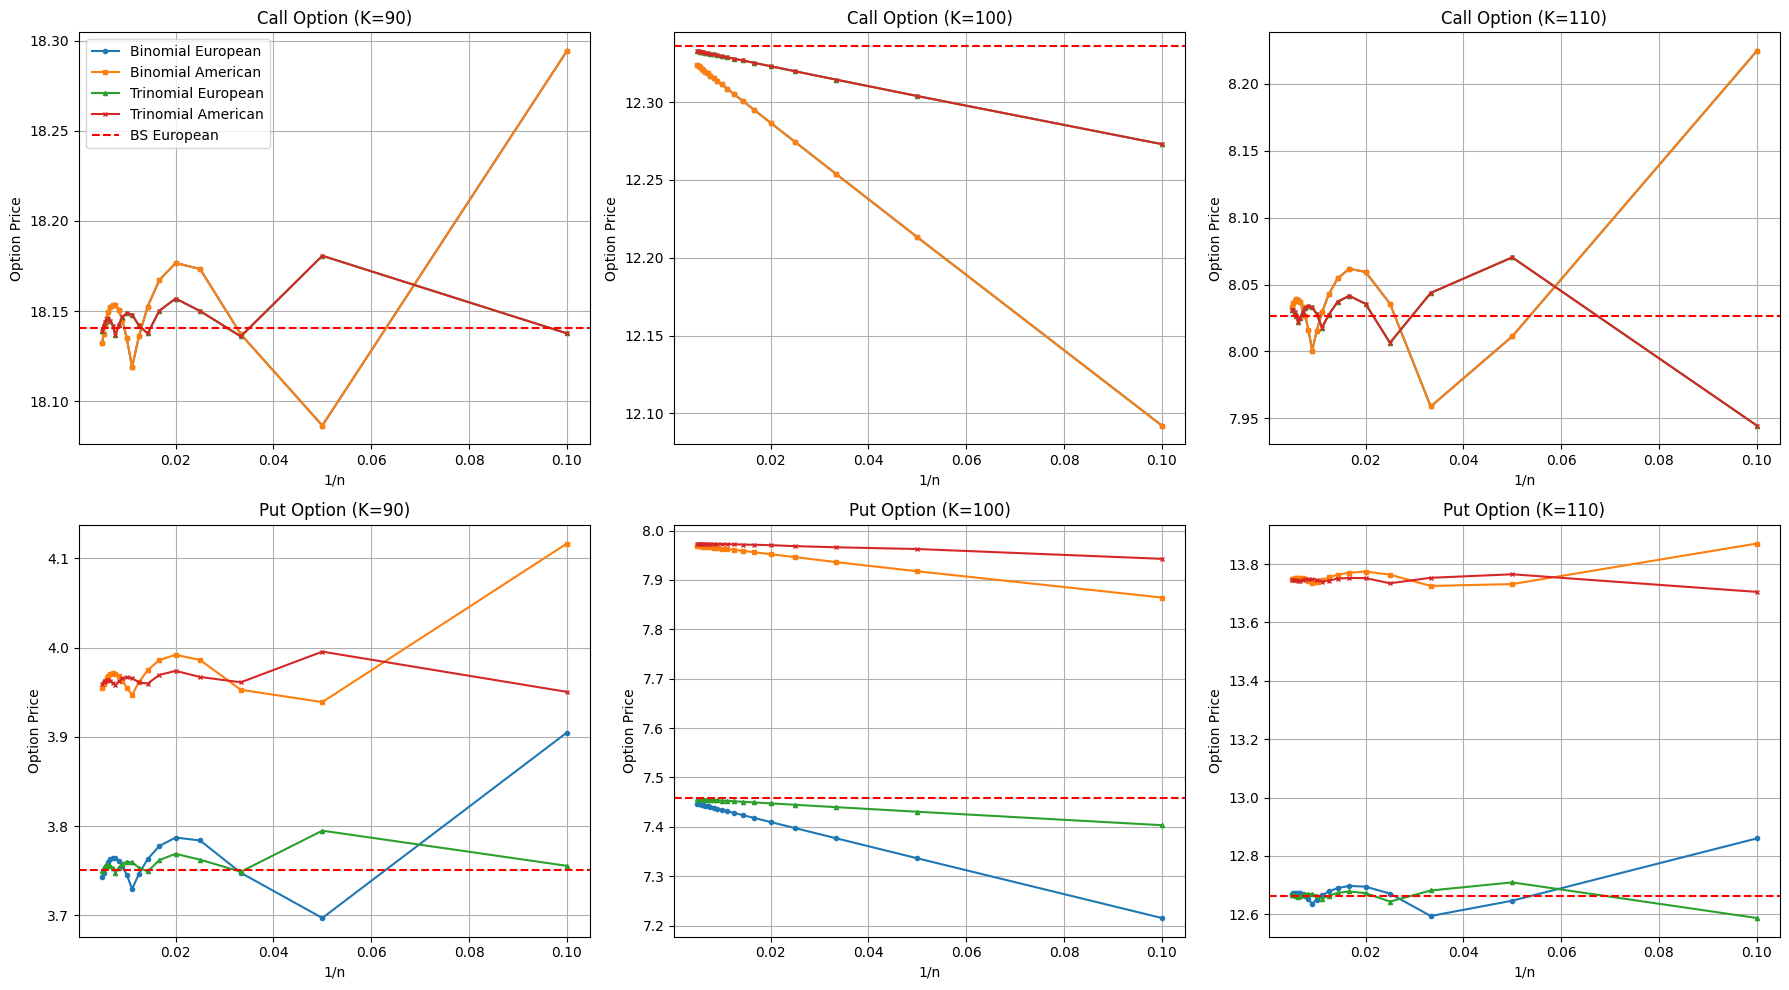

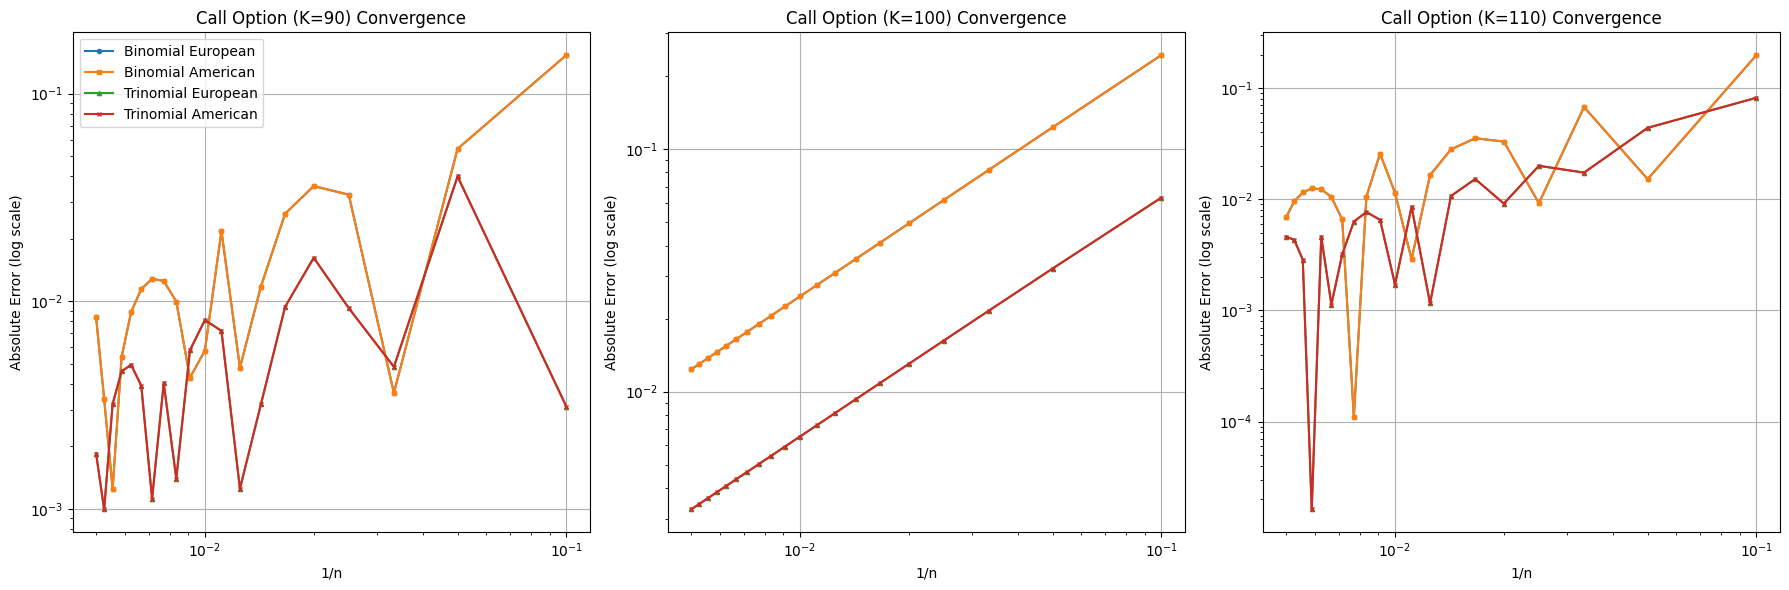

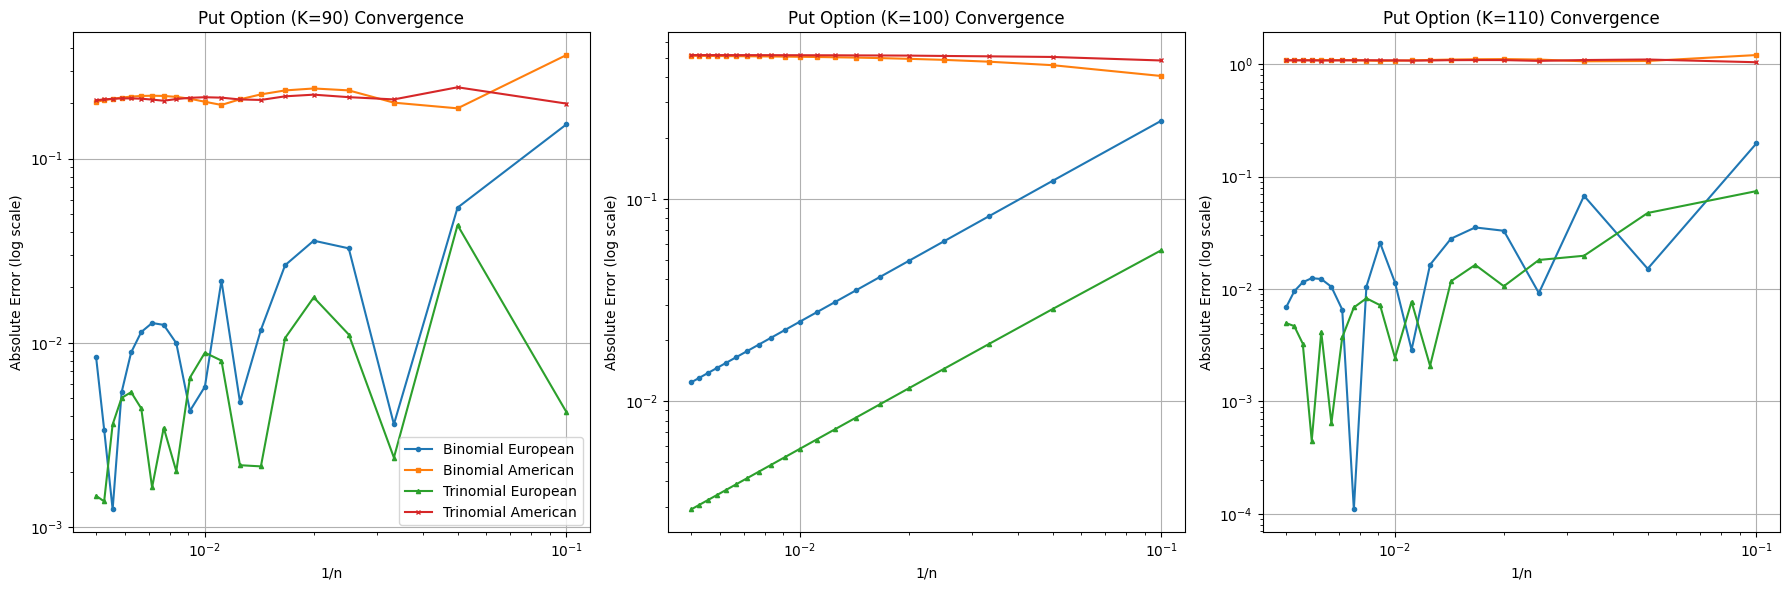

In [5]:
def compare_american_european_options():
    """Compare American and European options using binomial and trinomial trees"""
    # Parameters
    S0, r, sigma, T = 100, 0.05, 0.25, 1.0
    strikes = [90, 100, 110]
    option_types = ['call', 'put']
    n_range = np.arange(10, 201, 10)
    x_values = 1/n_range
    lambd = 1.2  # optimal lambda from previous analysis
    
    # Initialize plot structure - 2 rows (call, put) x 3 columns (K=90, 100, 110)
    fig, axes = plt.subplots(len(option_types), len(strikes), figsize=(18, 10))
    
    for i, option_type in enumerate(option_types):
        for j, K in enumerate(strikes):
            # Initialize models
            bs = BSOption(S0, K, r, sigma, T)
            bt = BinomialTree(S0, K, r, sigma, T)
            tt = TrinomialTree(S0, K, r, sigma, T)
            
            # Get European Black-Scholes price (reference)
            bs_price = bs.price(option_type)
            
            # Compute prices for different models and exercise types
            bt_euro_prices = []
            bt_amer_prices = []
            tt_euro_prices = []
            tt_amer_prices = []
            
            for n in n_range:
                # Binomial tree
                bt_euro_price = bt.price(n, option_type, 'european')
                bt_amer_price = bt.price(n, option_type, 'american')
                bt_euro_prices.append(bt_euro_price)
                bt_amer_prices.append(bt_amer_price)
                
                # Trinomial tree
                try:
                    tt_euro_price = tt.price(n, lambd, option_type, 'european')
                    tt_amer_price = tt.price(n, lambd, option_type, 'american')
                    tt_euro_prices.append(tt_euro_price)
                    tt_amer_prices.append(tt_amer_price)
                except Exception as e:
                    print(f"Error at n={n}, K={K}, option_type={option_type}: {e}")
                    tt_euro_prices.append(None)
                    tt_amer_prices.append(None)
            
            # Remove None values if any
            valid_indices = [i for i, x in enumerate(tt_euro_prices) if x is not None]
            if len(valid_indices) < len(n_range):
                tt_euro_prices = [tt_euro_prices[i] for i in valid_indices]
                tt_amer_prices = [tt_amer_prices[i] for i in valid_indices]
                tt_x_values = [x_values[i] for i in valid_indices]
            else:
                tt_x_values = x_values
            
            # Plot results
            ax = axes[i, j]
            ax.plot(x_values, bt_euro_prices, marker='o', markersize=3, label='Binomial European')
            ax.plot(x_values, bt_amer_prices, marker='s', markersize=3, label='Binomial American')
            ax.plot(tt_x_values, tt_euro_prices, marker='^', markersize=3, label='Trinomial European')
            ax.plot(tt_x_values, tt_amer_prices, marker='x', markersize=3, label='Trinomial American')
            ax.axhline(y=bs_price, color='r', linestyle='--', label='BS European')
            
            ax.grid(True)
            ax.set_xlabel('1/n')
            ax.set_ylabel('Option Price')
            ax.set_title(f'{option_type.capitalize()} Option (K={K})')
            
            # Only show legend for the first plot
            if i == 0 and j == 0:
                ax.legend()
    
    plt.tight_layout()
    plt.savefig('american_european_comparison.png')
    
    # Print a table of final values for comparison
    n_final = 200  # Use a high number of steps for final values
    print("\nComparison of American vs European Option Values (n=200):")
    print(f"{'Option Type':<10} {'Strike':<10} {'Model':<15} {'European':<15} {'American':<15} {'Difference':<15}")
    print("-" * 70)
    
    for option_type in option_types:
        for K in strikes:
            bt = BinomialTree(S0, K, r, sigma, T)
            tt = TrinomialTree(S0, K, r, sigma, T)
            bs = BSOption(S0, K, r, sigma, T)
            
            bt_euro = bt.price(n_final, option_type, 'european')
            bt_amer = bt.price(n_final, option_type, 'american')
            tt_euro = tt.price(n_final, lambd, option_type, 'european')
            tt_amer = tt.price(n_final, lambd, option_type, 'american')
            bs_price = bs.price(option_type)
            
            print(f"{option_type:<10} {K:<10} {'Black-Scholes':<15} {bs_price:<15.6f} {'N/A':<15} {'N/A':<15}")
            print(f"{option_type:<10} {K:<10} {'Binomial':<15} {bt_euro:<15.6f} {bt_amer:<15.6f} {bt_amer-bt_euro:<15.6f}")
            print(f"{option_type:<10} {K:<10} {'Trinomial':<15} {tt_euro:<15.6f} {tt_amer:<15.6f} {tt_amer-tt_euro:<15.6f}")
    
    # Also plot convergence of errors for binomial and trinomial trees
    for option_type in option_types:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        for j, K in enumerate(strikes):
            bs = BSOption(S0, K, r, sigma, T)
            bt = BinomialTree(S0, K, r, sigma, T)
            tt = TrinomialTree(S0, K, r, sigma, T)
            
            bs_price = bs.price(option_type)
            
            bt_euro_errors = []
            bt_amer_errors = []
            tt_euro_errors = []
            tt_amer_errors = []
            
            for n in n_range:
                bt_euro_price = bt.price(n, option_type, 'european')
                bt_amer_price = bt.price(n, option_type, 'american')
                bt_euro_errors.append(abs(bt_euro_price - bs_price))
                bt_amer_errors.append(abs(bt_amer_price - bs_price))  # Compare with BS as reference
                
                try:
                    tt_euro_price = tt.price(n, lambd, option_type, 'european')
                    tt_amer_price = tt.price(n, lambd, option_type, 'american')
                    tt_euro_errors.append(abs(tt_euro_price - bs_price))
                    tt_amer_errors.append(abs(tt_amer_price - bs_price))
                except Exception:
                    tt_euro_errors.append(None)
                    tt_amer_errors.append(None)
            
            # Remove None values if any
            valid_indices = [i for i, x in enumerate(tt_euro_errors) if x is not None]
            if len(valid_indices) < len(n_range):
                tt_euro_errors = [tt_euro_errors[i] for i in valid_indices]
                tt_amer_errors = [tt_amer_errors[i] for i in valid_indices]
                tt_x_values = [x_values[i] for i in valid_indices]
            else:
                tt_x_values = x_values
            
            ax = axes[j]
            ax.loglog(x_values, bt_euro_errors, marker='o', markersize=3, label='Binomial European')
            ax.loglog(x_values, bt_amer_errors, marker='s', markersize=3, label='Binomial American')
            ax.loglog(tt_x_values, tt_euro_errors, marker='^', markersize=3, label='Trinomial European')
            ax.loglog(tt_x_values, tt_amer_errors, marker='x', markersize=3, label='Trinomial American')
            
            ax.grid(True)
            ax.set_xlabel('1/n')
            ax.set_ylabel('Absolute Error (log scale)')
            ax.set_title(f'{option_type.capitalize()} Option (K={K}) Convergence')
            
            if j == 0:
                ax.legend()
        
        plt.tight_layout()
        plt.savefig(f'{option_type}_convergence_comparison.png')
    
    plt.show()

compare_american_european_options()

### 3.1 American vs. European Option Values
The numerical results show that for both call and put options, with interest rate r=0.05, there are differences between American and European option values:

For call options: The difference between American and European prices is nearly zero (≤0.000000) across all strike prices

For put options: Similarly, the difference is not zero for all cases

For American call options on non-dividend-paying stocks, it's never optimal to exercise an American call early when there are no dividends. Therefore, American calls have exactly the same value as European calls.

This is known as the "no early exercise theorem" for American calls.

For American put options, early exercise can be optimal, even without dividends. If the stock price falls significantly below the strike price, exercising early allows you to receive the strike price immediately and invest it at the risk-free rate (r=0.05).

This early exercise privilege makes American puts more valuable than European puts.

### 3.2 Convergence Characteristics
The convergence plots reveal distinct patterns for different strike prices:

At-the-money options (K=100): Both models show remarkably straight-line convergence in log-log scale, indicating power-law convergence. The trinomial tree consistently provides lower error rates than the binomial tree.
In/Out-of-the-money options (K=90, K=110): These exhibit more erratic convergence patterns with significant oscillations, especially for the binomial tree method. These oscillations reflect sensitivity to grid placement relative to the strike price.

### 3.3 Binomial vs. Trinomial Tree Performance
From the price plots and convergence plots:

Trinomial trees provide more stable and faster convergence across all strike prices. For K=100, the error reduction is approximately one order of magnitude compared to the binomial method.

Binomial trees show stronger oscillations and slower convergence, particularly pronounced for K=90 and K=110 where the convergence pattern exhibits significant zigzagging.

### 3.4 Impact of Strike Price (Moneyness)
As the strike price increases from 90 to 110, the price difference for Put options increases from 0.21 to 1.08. Higher strike puts are more in-the-money, making early exercise more valuable.

Moreover, the effect of moneyness on convergence is clearly visible:

At-the-money (K=100): Both methods converge most predictably, with clean linear patterns in log-log error plots

In-the-money call/Out-of-the-money put (K=90): Shows more oscillatory behavior

Out-of-the-money call/In-the-money put (K=110): Exhibits similar oscillation patterns to K=90, but with different amplitudes
